In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mediapipe as mp
from IPython.display import HTML
import ipywidgets as widgets
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve
from STGCN import SpatialTemporalGraphConvNetwork
from tqdm import tqdm

In [33]:
class MyDataset(Dataset):
    def __init__(self, root_dir, augment_prob=0.5, zero_frames_prob=0.0):
        self.augment_prob = augment_prob
        self.zero_frames_prob = zero_frames_prob
        
        self.data = []
        for i in range(len(os.listdir(root_dir))):
            path = os.path.join(root_dir, "class_" + str(i))
            class_data = os.listdir(path)
            for sample_path in class_data:
                sample_full_path = os.path.join(path, sample_path)
                sample = np.load(sample_full_path)
                self.data.append((sample, i))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, label = self.data[index]
        if np.random.rand() < self.augment_prob:
            sample = self.augmentation_flip(sample)

        if np.random.rand() < self.augment_prob:
            sample = self.augmentation_zero_frames(sample)

        # [T, N, C] -> [C, T, N]
        sample = np.transpose(sample, (2, 0, 1))
        sample = torch.from_numpy(sample)
        y = torch.tensor(label, dtype=torch.long)

        return sample, y

    def augmentation_zero_frames(self, sample):
        # we will zero some frames with prob zero_frames_prob
        indexes = np.random.rand(sample.shape[0])
        indexes = np.where(indexes < self.zero_frames_prob)
        sample[indexes, :, :] = 0
        return sample

    @staticmethod
    def augmentation_flip(sample):
        # sample shape is [T, N, C]
        sample[:, :, 0] = 1 - sample[:, :, 0]
        return sample


class MySubset(MyDataset):
    def __init__(self, augment_prob=0.5, zero_frames_prob=0.0):
        self.data = []
        self.indicies = []
        self.augment_prob = augment_prob
        self.zero_frames_prob = zero_frames_prob
    
    def add_samples(self, data, indicies):
        for index in indicies:
            self.data.append(data[index])
            self.indicies.append(index)

In [36]:
def sep_data(dataset, batch_size, split_ratio=[0.8, 0.1, 0.1]):
    if sum(split_ratio) > 1:
        return f'sum of ratio should be 1 or lower'
    
    train_data, val_data, test_data = MySubset(), MySubset(), MySubset()
    num_samples = len(dataset)
    train_num_samples = int(split_ratio[0] * num_samples)
    val_num_samples = int(split_ratio[1] * num_samples)
    test_num_samples = int((1 - sum(split_ratio)) * num_samples) if len(split_ratio) == 2 else int(split_ratio[2] * num_samples)

    indicies = np.arange(len(dataset))
    np.random.shuffle(indicies)
    train_data.add_samples(dataset.data, indicies[:train_num_samples])
    val_data.add_samples(dataset.data, indicies[train_num_samples:(train_num_samples + val_num_samples)])
    test_data.add_samples(dataset.data, indicies[(train_num_samples + val_num_samples):])
    
    val_data.augment_prob = 0
    test_data.augment_prob = 0 

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_dataloader, val_dataloader, test_dataloader


dataset = MyDataset(root_dir="dataset")
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader, val_dataloader, test_dataloader = sep_data(dataset, batch_size)

print(f'Train samples: {len(train_dataloader) * batch_size}')
print(f'Val samples: {len(val_dataloader) * batch_size}')
print(f'Test samples: {len(test_dataloader) * batch_size}')
print(f'Device: {device}')

Train samples: 608
Val samples: 80
Test samples: 80
Device: cpu


In [37]:
def train_stgcn(model, loss_instance, data_loader, optimizer, epoch, epochs, verbose=True, device=device):
    model.to(device)
    model.train()
    total_loss = 0.0
    total_num = 0

    if verbose:
        data_bar = tqdm(data_loader)
    
    for data, label in data_bar:
        data, label = data.to(device), label.to(device)

        logits = model(data)

        optimizer.zero_grad()
        loss = loss_instance(logits, label)
        loss.backward()
        optimizer.step()

        batch_size = len(label)
        total_num += batch_size
        total_loss += loss.item() * batch_size

        if verbose:
            data_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))
    
    return total_loss / total_num

def eval_stgcn(model, data_loader, device=device):
    model.to(device)
    model.eval()
    results = {}
    true_predict = 0
    total_predict = 0
    with torch.no_grad():
        for item in data_loader:
            data, label = item
            data, label = data.to(device), label.to(device)
            logits = model(data)

            true_predict += (torch.argmax(logits, dim=1) == label).sum().item()
            total_predict += label.size(0)

        accuracy = true_predict / total_predict

    results['accuracy%'] = accuracy * 100
    results['logits'] = logits
    
    return results

In [38]:
def train_model(model=None, loss_instance=None, optimizer=None, train_dataloader=None, val_dataloader=None, epochs=25, save=False, save_file_name='default', verbose=True, device=device):
    results = {'loss_history': [],
    'train_acc_history':[],
    'val_acc_history': []}

    if not(model and loss_instance and optimizer and train_dataloader and val_dataloader):
        print(f'You should pass everything!')
        return None
    
    for epoch in range(epochs):
        train_loss = train_stgcn(model, loss_instance, train_dataloader, optimizer, epoch, epochs, verbose, device)
        train_results = eval_stgcn(model, train_dataloader, device)
        val_results = eval_stgcn(model, val_dataloader, device)
        results['loss_history'].append(train_loss)
        results['train_acc_history'].append(train_results['accuracy%'])
        results['val_acc_history'].append(val_results['accuracy%'])

        if save:
            torch.save({'model_params': model.state_dict(),
               'results': results}, save_file_name)

    return model, results

In [39]:
model = SpatialTemporalGraphConvNetwork(2, 3, 21, device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=7.5e-5)
loss_instance = CrossEntropyLoss()

summary(model, input_size=(3, 30, 21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GraphConv-1           [-1, 64, 30, 21]               0
            Conv2d-2           [-1, 64, 30, 21]          36,928
       BatchNorm2d-3           [-1, 64, 30, 21]             128
              ReLU-4           [-1, 64, 30, 21]               0
        STGCNBlock-5           [-1, 64, 30, 21]               0
         GraphConv-6          [-1, 128, 30, 21]               0
            Conv2d-7          [-1, 128, 30, 21]         147,584
       BatchNorm2d-8          [-1, 128, 30, 21]             256
              ReLU-9          [-1, 128, 30, 21]               0
       STGCNBlock-10          [-1, 128, 30, 21]               0
        GraphConv-11          [-1, 196, 30, 21]               0
           Conv2d-12          [-1, 196, 30, 21]         345,940
      BatchNorm2d-13          [-1, 196, 30, 21]             392
             ReLU-14          [-1, 196,

In [40]:
epochs = 250

loss_history = []
train_acc_history = []

if 'baseline.pth' in os.listdir():
    answr = int(input(f'wanna load baseline model?\n0 - No\n1 - Yes\n'))

if not(answr):
    model, results = train_model(model=model,
                loss_instance=loss_instance,
                optimizer=optimizer,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                epochs=epochs,
                save=int(input(f'wanna save new baseline model?\n0 - No\n1 - Yes\n')),
                save_file_name='baseline.pth',
                verbose=True,
                device=device)
else:
    baseline_dict = torch.load('baseline.pth', map_location='cpu', weights_only=False)
    model.load_state_dict(baseline_dict['model_params'])
    results = baseline_dict['results']
    
loss_history, train_acc_history, val_acc_history = results['loss_history'], results['train_acc_history'], results['val_acc_history']

wanna load baseline model?
0 - No
1 - Yes
 1


In [83]:
print(f'Baseline accuracies:\n')
print(f'accuracy on val dataset: {eval_stgcn(model, val_dataloader, device)['accuracy%']:.0f}%')
print(f'accuracy on train dataset: {eval_stgcn(model, train_dataloader, device)['accuracy%']:.0f}%')

Baseline accuracies:

accuracy on val dataset: 84%
accuracy on train dataset: 81%


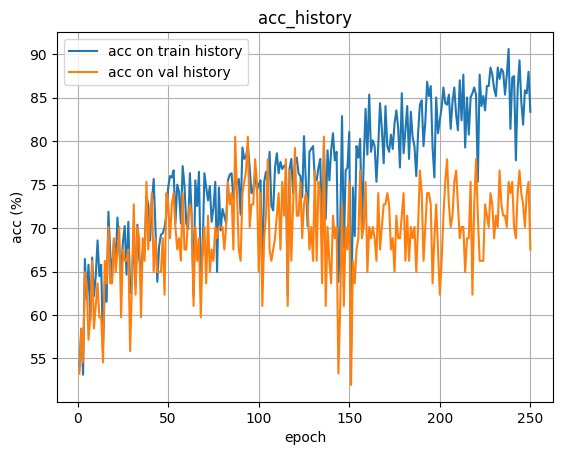

In [45]:
def plot_history(plot_title, ylabel, xlabel, arg_dict):
    for key, value in arg_dict.items():
        plt.plot(np.arange(1, epochs + 1), value, label=key)
    plt.title(plot_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.grid()
    plt.show()

arg_dict = {'acc on train history': train_acc_history,
            'acc on val history': val_acc_history}

plot_history('acc_history', 'acc (%)', 'epoch', arg_dict)

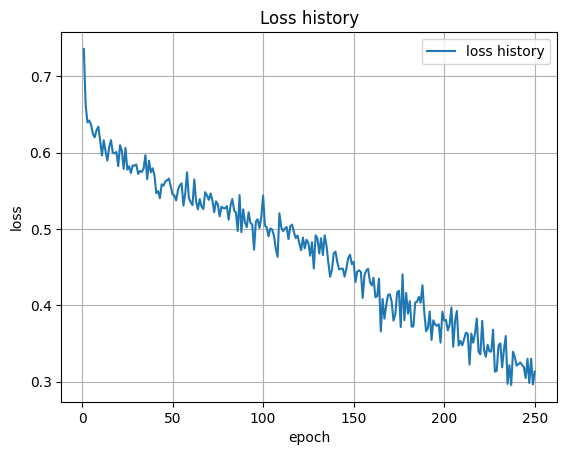

In [46]:
arg_dict = {'loss history': loss_history}

plot_history('Loss history', 'loss', 'epoch', arg_dict)

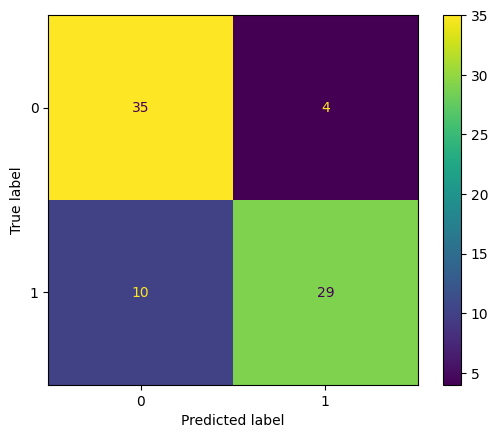

In [58]:
def print_confusion_matrix(model, test_dataloader):
    model = model.eval()
    y_pred_ = []
    label_ = []
    data_ = []
    
    with torch.no_grad():
        for item in test_dataloader:
            data, label = item
            data, label = data.to(device), label.to(device)
            y_pred_ += list(torch.argmax(model(data), dim=1).cpu())
            label_ += list(label.cpu())
            data_ += list(data.cpu())

    y_pred_ = np.array(y_pred_)
    label_ = np.array(label_)
    data_ = np.array(data_)
    
    data_fn = data_[(y_pred_ == 0) & (label_ == 1)]
    data_fp = data_[(y_pred_ == 1) & (label_ == 0)]
    
    cm = confusion_matrix(label_, y_pred_)
    ConfusionMatrixDisplay(cm).plot()
    
    return data_fn, data_fp

data_fn, data_fp = print_confusion_matrix(model, test_dataloader)

In [62]:
HAND_CONNECTIONS = mp.solutions.hands.HAND_CONNECTIONS
current_idx = 0
    
output = widgets.Output()
label = widgets.Label()

def create_anim(data, n):
    fig, ax = plt.subplots()
    hand_pic = ax.scatter(data[n, 0, 0, :], data[n, 1, 0, :], c='red')
    
    ax.set_xlim(np.min(data[n, 0, :, :]) - 1, np.max(data[n, 0, :, :]) + 1)
    ax.set_ylim(np.min(data[n, 1, :, :]) - 1, np.max(data[n, 1, :, :]) + 1)
    ax.set_aspect('equal')
    
    lines = []
    for (start, end) in HAND_CONNECTIONS:
        line, = ax.plot(
            [data[n, 0, 0, start], data[n, 0, 0, end]],
            [data[n, 1, 0, start], data[n, 1, 0, end]],
            c='blue'
        )
        lines.append(line)
    
    
    def update(i):
        coords = np.stack([data[n, 0, i, :], data[n, 1, i, :]], axis=-1)
        hand_pic.set_offsets(coords)
    
        for line, (start, end) in zip(lines, HAND_CONNECTIONS):
            xdata = [data[n, 0, i, start], data[n, 0, i, end]]
            ydata = [data[n, 1, i, start], data[n, 1, i, end]]
            line.set_data(xdata, ydata)
            
        return [hand_pic, *lines] 
    
    ani = animation.FuncAnimation(fig, update, interval=100, frames=data.shape[2])
    plt.close(fig)

    with output:
        output.clear_output(wait=True)
        display(HTML(ani.to_jshtml()))

    label.value = f"Sample: {n} / {data.shape[0]-1}"
    jump_box.value = n

def on_prev_clicked(data, b):
    global current_idx
    current_idx = (current_idx - 1) % data.shape[0]
    create_anim(data, current_idx)

def on_next_clicked(data, b):
    global current_idx
    current_idx = (current_idx + 1) % data.shape[0]
    create_anim(data, current_idx)

def on_jump_change(data, change):
    global current_idx
    if change['name'] == 'value' and isinstance(change['new'], int):
        idx = change['new']
        if 0 <= idx < data.shape[0]:
            current_idx = idx
            create_anim(data, current_idx)


n = int(input(f'Введите какие данные вы хотите посмотреть в анимации:\n0 - FP\n1 - FN\n'))

if n == 0:
    data = data_fp
elif n == 1:
    data = data_fn

prev_button = widgets.Button(description="Prev")
next_button = widgets.Button(description="Next")
jump_box = widgets.BoundedIntText(
    value=0, min=0, max=data.shape[0]-1, description="Go to:"
)

prev_button.on_click(lambda b: on_prev_clicked(data, b))
next_button.on_click(lambda b: on_next_clicked(data, b))
jump_box.observe(lambda change: on_jump_change(data, change), names='value')

buttons = widgets.HBox([prev_button, next_button, jump_box])
ui = widgets.VBox([label, buttons])
display(ui, output)

create_anim(data, current_idx)

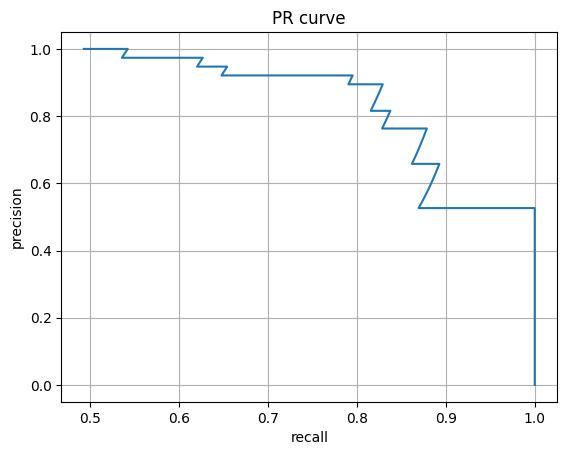

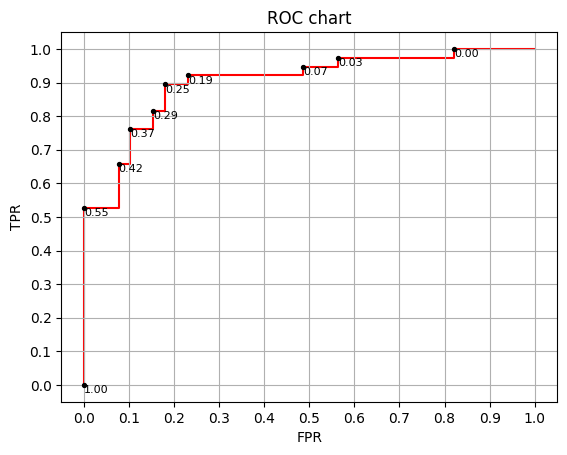

In [104]:
def get_metrics(model, dataloader, device=device):
    model.to(device)
    
    y_real = []
    y_prob = []
    metrics = {}
    with torch.no_grad():
        for data, y in dataloader:
            data, y = data.to(device), y.to(device)
            logits = model(data)
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(logits)
            y_real += list(y.cpu())
            y_prob += list(probs[:, 1].cpu())

    metrics['precision_recall_curve'] = precision_recall_curve(y_real, y_prob)
    metrics['roc_curve'] = roc_curve(y_real, y_prob)
    
    return metrics

metrics = get_metrics(model, val_dataloader)

precision_history, recall_history, tresholds = metrics['precision_recall_curve']
FPR, TPR, thresholds_ = metrics['roc_curve']

plt.plot(precision_history, recall_history)
plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')
plt.grid()
plt.show()


n_points = len(thresholds_)
step = max(n_points // 10, 1)  # every ~5%

for i in range(0, n_points, step):
    threshold = thresholds_[i]
    if i == 0:
        threshold = 1
    x = FPR[i]
    y = TPR[i]
    plt.text(x, y, f'{threshold:.2f}', fontsize=8, ha='left', va='top', alpha=1, color='black', zorder=2)
    plt.scatter(x, y, s=8, c='black', zorder=2)

plt.plot(FPR, TPR, color='red', zorder=1)
plt.title(f'ROC chart')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()

In [1]:
# def objective(trial):
#     params = dict(
#         optimizer_lr=trial.suggest_float("optimizer_lr", 1e-4, 1e-2, log=True),
#         batch_size=trial.suggest_int("batch_size", 4, 32)
#     )

#     epochs = 50
#     model = SpatialTimeGraphConvNetwork(2, 3, 21, device=device)
#     loss_instance = CrossEntropyLoss()
#     optimizer = torch.optim.AdamW(params=model.parameters(), lr=params['optimizer_lr'])
#     batch_size = params['batch_size']

#     train_dataloader, val_dataloader, test_dataloader = sep_data(dataset, batch_size)

#     model, _ = train_model(model=model,
#                 loss_instance=loss_instance,
#                 optimizer=optimizer,
#                 train_dataloader=train_dataloader,
#                 val_dataloader=val_dataloader,
#                 epochs=epochs,
#                 save=False,
#                 save_file_name='default.pth',
#                 verbose=False,
#                 device=device)

#     return eval_stgcn(model=model, data_loader=val_dataloader, device=device) 

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)
# model_best_params = study.best_params